In [1]:
%reload_ext autoreload
%autoreload 2

In [9]:
import jupytools.syspath
jupytools.syspath.add('..')

In [65]:
from collections import OrderedDict
import feather
import pandas as pd
from tqdm.auto import tqdm
from dataset import load, n_unique, missing_info, existing_info, Subset
from style import NotebookStyle

In [11]:
pd.options.display.max_rows = 2000

In [12]:
NotebookStyle().override()

In [13]:
trn_data, trn_target, trn_specs = load(Subset.Train)

(11341042, 11) (17690, 7) (386, 3) 

In [124]:
[tst_data] = load(Subset.Test)

(1156414, 11) 

In [15]:
trn_event = feather.read_dataframe('trn_event.feather')

In [16]:
trn_data['timestamp'] = pd.to_datetime(trn_data['timestamp']) 

In [17]:
dataset = pd.concat([trn_data.drop(columns='event_data'), 
                     trn_event.drop(columns=['game_time'])], axis=1)

In [18]:
for inst_id, g in dataset.groupby('installation_id'):
    if not g.title.str.contains('\(Assessment\)').any():
        continue
    g = g.sort_values(by=['timestamp'])
    break

/home/ck/anaconda3/envs/fastai_10/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


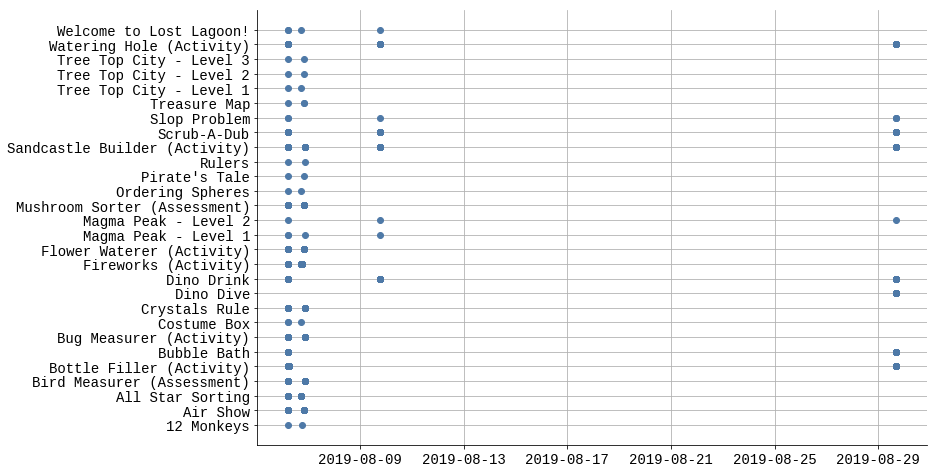

In [19]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ts = g.timestamp.tolist()
titles = sorted(g.title.unique())
title_map = dict([(t, i) for i, t in enumerate(titles)])
ys = [title_map[t] for t in g.title]
ax.scatter(ts, ys)
ax.set_yticks(list(range(len(titles))))
ax.set_yticklabels(titles)
ax.grid(True)
ax.set_axisbelow(True)

In [107]:
has_assessments = (
    trn_target[trn_target.title.str.contains('\(Assessment\)')]
    .installation_id
    .unique()
    .tolist())
labels_dataset = dataset[dataset.installation_id.isin(has_assessments)].copy()
labels_dataset.sort_values(by='timestamp', inplace=True)
print(set(labels_dataset.installation_id) == set(trn_target.installation_id))
print(set(labels_dataset.game_session) == set(trn_target.game_session))

True
False


In [75]:
from utils import parallel_chain

In [79]:
inst_groups = [g for _, g in labels_dataset.groupby('installation_id')]

In [90]:
def process_rows(g):
    g = g.reset_index(drop=True)
    assessments = g.index[g.title.str.contains('\(Assessment\)')].tolist()
    rows = []
    
    for i, line_no in enumerate(assessments):
        asm = g.iloc[:line_no+1].copy()
        n = len(asm)
        row = OrderedDict()

        row['game_session'] = asm.game_session.iloc[-1]
        row['installation_id'] = asm.installation_id.iloc[-1] 
        row['prev_assignments'] = i
        
        row['events_count'] = n
        row['game_session_uniq'] = len(asm.game_session.unique())
        row['title_uniq'] = len(asm.title.unique())

        event_cnt = asm.event_code.value_counts()
        row['event_count_max'] = asm.event_count.max()
        row['event_code_least'] = event_cnt.index[-1]
        row['event_code_most'] = event_cnt.index[0]
        row['event_code_uniq'] = len(event_cnt)

        row['game_time_min'] = asm.game_time.min()
        row['game_time_max'] = asm.game_time.max()
        row['game_time_mean'] = asm.game_time.mean()
        row['game_time_std'] = asm.game_time.std()
        row['game_time_skew'] = asm.game_time.skew()
        row['game_time_sum'] = asm.game_time.sum()

        type_cnt = asm.type.value_counts()
        row['type_uniq'] = len(type_cnt)
        row['type_least'] = type_cnt.index[-1]
        row['type_most'] = type_cnt.index[0]
        row['type_clip_count'] = type_cnt.get('Clip', 0)
        row['type_activity_count'] = type_cnt.get('Activity', 0)
        row['type_game_count'] = type_cnt.get('Game', 0)
        row['type_assessment_count'] = type_cnt.get('Assessment', 0)
        row['type_clip_freq'] = row['type_clip_count']/n
        row['type_activity_freq'] = row['type_activity_count']/n
        row['type_game_freq'] = row['type_game_count']/n
        row['type_assessment_freq'] = row['type_assessment_count']/n

        world_cnt = asm.world.value_counts()
        row['world_uniq'] = len(world_cnt)
        row['world_least'] = world_cnt.index[-1]
        row['world_most'] = world_cnt.index[0]
        row['world_none_count'] = world_cnt.get('NONE', 0)
        row['world_magmapeak_count'] = world_cnt.get('MAGMAPEAK', 0)
        row['world_treetopcity_count'] = world_cnt.get('TREETOPCITY', 0)
        row['world_crystalcaves_count'] = world_cnt.get('CRYSTALCAVES', 0)
        row['world_none_freq'] = row['world_none_count']/n
        row['world_magmapeak_freq'] = row['world_magmapeak_count']/n
        row['world_treetopcity_freq'] = row['world_treetopcity_count']/n
        row['world_crystalcaves_freq'] = row['world_crystalcaves_count']/n

        media_cnt = asm.media_type.value_counts()
        row['media_uniq'] = len(media_cnt)
        row['media_least'] = media_cnt.index[-1]
        row['media_most'] = media_cnt.index[0]
        row['media_none_count'] = media_cnt.get('none', 0)
        row['media_audio_count'] = media_cnt.get('audio', 0)
        row['media_animation_count'] = media_cnt.get('animation', 0)
        row['media_none_freq'] = row['media_none_count']/n
        row['media_audio_freq'] = row['media_audio_count']/n
        row['media_animation_freq'] = row['media_animation_count']/n

        rows.append(row)
        
    return rows

In [112]:
X = pd.DataFrame(parallel_chain(process_rows, inst_groups, 12))

In [115]:
X_dedup = X.drop_duplicates(subset=['game_session', 'installation_id'], keep='last')
X_dedup = X_dedup.reset_index(drop=True)
X_dedup = X_dedup[X_dedup.game_session.isin(trn_target.game_session)]

In [116]:
print(set(X_dedup.game_session) == set(trn_target.game_session))
print(set(X_dedup.installation_id) == set(trn_target.installation_id))

True
True


In [120]:
y = trn_target.accuracy_group.values

In [122]:
import catboost as cb

In [ ]:
params = dict(
    
)
cb.train(params=params)

In [125]:
inst_groups = [g for _, g in labels_dataset.groupby('installation_id')]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,2019-09-10T16:50:24.910Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,2019-09-10T16:50:55.503Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10T16:51:51.805Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10T16:53:12.825Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10T16:54:12.115Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES
...,...,...,...,...,...,...,...,...,...,...,...
1156409,c74f40cd,46ff9d3ad2be09f2,2019-09-28T21:20:40.918Z,"{""description"":""Alright! This one is the littl...",ffe774cc,39,3121,32030,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
1156410,6c930e6e,46ff9d3ad2be09f2,2019-09-28T21:20:41.493Z,"{""duration"":20008,""misses"":0,""event_count"":40,...",ffe774cc,40,2030,32584,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
1156411,a5be6304,46ff9d3ad2be09f2,2019-09-28T21:20:45.499Z,"{""session_duration"":36607,""exit_type"":""game_co...",ffe774cc,41,2010,36607,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
1156412,27253bdc,96d7dc31e822cedc,2019-09-28T21:21:05.670Z,"{""event_code"": 2000, ""event_count"": 1}",ffe774cc,1,2000,0,Tree Top City - Level 3,Clip,TREETOPCITY
